In [1]:
%load_ext nb_black
%matplotlib inline

<IPython.core.display.Javascript object>

In [2]:
## setup code
import matplotlib.pyplot as plt

plt.style.use("seaborn")
plt.rc("figure", figsize=(15, 3))
import numpy as np
import msprime as msp

np.random.seed(1)

<IPython.core.display.Javascript object>

# Quick start guide
This packages implements methods described in [the paper](https://doi.org/10.1101/2020.09.21.307355):

    Exact decoding of the sequentially Markov coalescent
    Caleb Ki, Jonathan Terhorst
    bioRxiv 2020.09.21.307355; doi:10.1101/2020.09.21.307355
    
The methods are implemented in a Python package called `xsmc`. The package has two main uses: drawing exact samples from the posterior distribution, and fast estimation of the maximum *a posteriori* (MAP) path. Convenience methods are also included for plotting.

We will demonstrate how the method works on simulated data using `msprime`.

In [3]:
def simulate(recombination_rate, length, sample_size=2):
    return msp.simulate(
        sample_size=sample_size,
        mutation_rate=1e-8,
        recombination_rate=recombination_rate,
        Ne=1e4,
        length=length,
        random_seed=np.random.randint(1, int(4e9)),
        demographic_events=[
            msp.PopulationParametersChange(time=0.0, initial_size=1e5),
            msp.PopulationParametersChange(time=1000.0, initial_size=1e4),
        ],
    )

<IPython.core.display.Javascript object>

All methods are accessed by creating an instance of the `xsmc.XSMC` class. The class has three required arguments:

- `ts`, a `tskit.TreeSequence` instance containing the data.
- `focal`, the node id of the focal haplotype in `ts`.
- `panel`, a list of node ids in `ts` which are potential targets for `focal` to copy from.

First, we
focus on the simplest type of analysis, where we have two chromosomes sampled from a singled diploid individual.

In [4]:
from xsmc import XSMC, Segmentation

data = simulate(recombination_rate=1e-9, length=1e6, sample_size=2)
xs = XSMC(data, focal=0, panel=[1], rho_over_theta=0.1)

<IPython.core.display.Javascript object>

## Exact sampling
To sample paths from the posterior, use the `XSMC.sample()`.

In [5]:
paths = xs.sample(k=100, seed=1)

<IPython.core.display.Javascript object>

The returned object is a list of length `k` of `Segmentation` objects. These objects can be easily plotted to visualize the posterior:

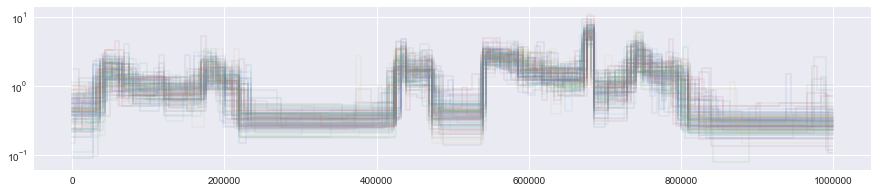

<IPython.core.display.Javascript object>

In [6]:
for p in paths:
    p.draw(alpha=0.1)
plt.yscale("log")

To compare the posterior with the truth, we can use built-in convenience methods to turn data into a `Segmentation` object and plot it.

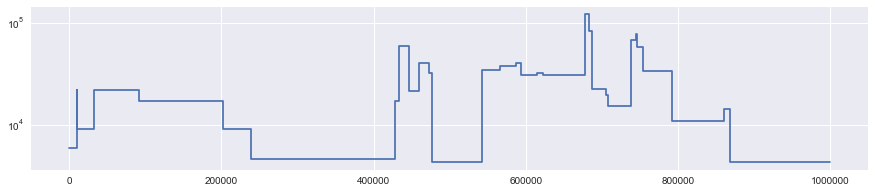

<IPython.core.display.Javascript object>

In [7]:
truth = Segmentation.from_ts(data, focal=0, panel=[1])
truth.draw()
plt.yscale("log")

### Rescaling the output
You may notice that the $y$ scale of the above plots is different. By default, `Segmentation`s returned by `XSMC` are in units of coalescent time. This matches the scaling of the Li & Durbin's PSMC.

To convert these times to generations, you must know the biological mutation rate $\mu$, and then estimate $N_0$ by the formula $N_0 = \theta / (4 \mu)$:

In [8]:
N0 = xs.theta / (4 * 1e-8)

<IPython.core.display.Javascript object>

Then, you can convert time to generations by multiplying by $2N_0$.

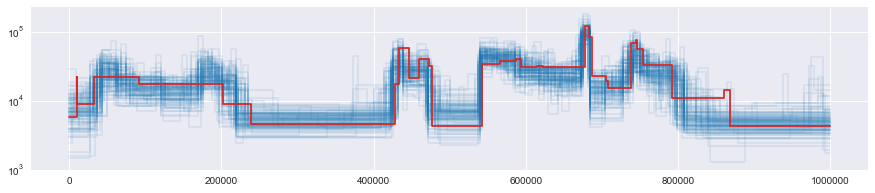

<IPython.core.display.Javascript object>

In [9]:
for p in paths:
    p.rescale(2 * N0).draw(
        color="tab:blue", alpha=0.1
    )  # divide by the mutation rate used in the simulation, convert to haploid
truth.draw(color="tab:red")
plt.yscale("log")
# plt.ylim(0, 1e4)

### Computing functionals of the posterior
The `Segmentation.to_pp()` method can be used to get access to the raw stepwise function it represents (returned as a **p**iecewise **p**olynomial, whence the name). By calling this method on paths returned from `XSMC.sample_paths()`, this you can compute functionals of the posterior distribution.

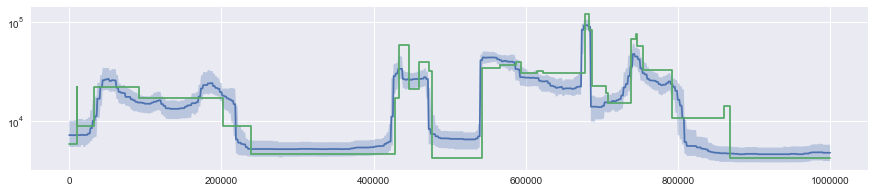

<IPython.core.display.Javascript object>

In [10]:
x = np.linspace(0, data.get_sequence_length(), 1000)
y = np.array([p.to_pp()(x) for p in paths])
q = (
    np.quantile(y, [0.25, 0.5, 0.75], axis=0) * 2 * N0
)  # faster than calling .rescale() on each path
plt.plot(x, q[1])
plt.fill_between(x, q[0], q[2], alpha=0.3)
truth.draw()
plt.yscale("log")

### Multiple samples
We can analyze multiple samples using a "trunk approximation" described in the paper. In this case, the returned segmentation approximates the earliest time to coalescence with any member of the panel.

In [11]:
data = simulate(recombination_rate=1e-8, length=1e6, sample_size=20)
focal = 0
panel = list(range(1, 20))
xs = XSMC(data, focal=focal, panel=panel, rho_over_theta=1.0)
paths = xs.sample(k=100, seed=1)

<IPython.core.display.Javascript object>

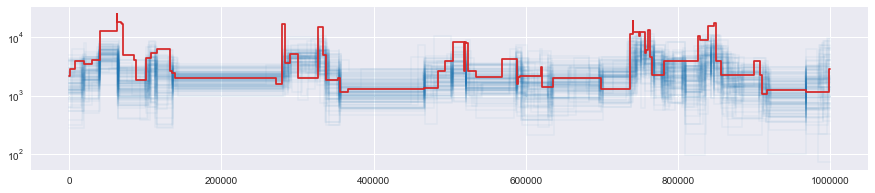

<IPython.core.display.Javascript object>

In [12]:
N0 = xs.theta / (4 * 1e-8)
for p in paths:
    p.rescale(2 * N0).draw(color="tab:blue", alpha=0.05)
truth = Segmentation.from_ts(data, focal=focal, panel=panel)
truth.draw(color="tab:red")
plt.yscale("log")

## Viterbi Decoding
The other function of the `XSMC` class is to compute the Viterbi/most probable path under the posterior:

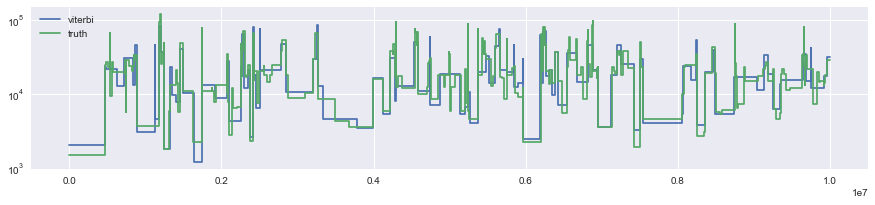

<IPython.core.display.Javascript object>

In [13]:
data = simulate(recombination_rate=1e-9, length=10e6, sample_size=10)
xs = XSMC(data, 0, [1, 2], rho_over_theta=1e-9 / 1.4e-8)
N0 = xs.theta / (4 * 1e-8)
map_path = xs.viterbi()
map_path.rescale(2 * N0).draw(label="viterbi")
Segmentation.from_ts(data, 0, [1, 2]).draw(label="truth")
plt.yscale("log")
plt.legend()

Note that each path also includes a haplotype component which is not plotted:

In [14]:
map_path.segments[0]

Segment(hap=2, interval=array([     0, 476205]), height=0.08770837623933274, mutations=21)

<IPython.core.display.Javascript object>

This says that the first segment in the MAP path had height 0.09 (in coalecent units) and coalesced with panel haplotype 2.